In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter hide_code
{% do SectionField(
    name='PRIMARY',
    title='KEA3 Consensus Kinases',
    subtitle='This appyter returns consensus kinases using a set of gene sets',
    img='kea3.png'
) %}

In [3]:
%%appyter markdown

{% set title = StringField(
    name='title',
    label='Notebook name',
    default='KEA3 Consensus Kinases',
    section="PRIMARY",
    constraint='[^<>]*'
) %}

# {{ title.raw_value }}




# KEA3 Consensus Kinases

In [4]:
import time
import requests
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, IFrame, Markdown
import math
import scipy.stats as st
import fastcluster

In [5]:
clustergrammer_url = 'https://maayanlab.cloud/clustergrammer/matrix_upload/'
API_URL = 'https://maayanlab.cloud/kea3/api/enrich/'
# libraries = ["ChEA_2016", "GO_Biological_Process_2018" ,"GWAS_Catalog_2019" , "KEGG_2019_Human"]
table = 1
figure = 1

## Get Input

In [6]:
%%appyter code_exec


{% set input_gene_set = FileField(
    name='input_gene_set',
    label='Gene Set',
    default='SARS-CoV-2_differentially_phosphorelated_proteins_down.gmt',
    section="PRIMARY",
    examples={
        'SARS-CoV-2_differentially_phosphorelated_proteins_down.gmt': 'https://appyters.maayanlab.cloud/storage/KEA3Consensus/SARS-CoV-2_differentially_phosphorelated_proteins_down.gmt',
        'SARS-CoV-2_differentially_phosphorelated_proteins_up.gmt': 'https://appyters.maayanlab.cloud/storage/KEA3Consensus/SARS-CoV-2_differentially_phosphorelated_proteins_up.gmt'
    }
) %}

input_gene_set = {{ input_gene_set }}

```python

input_gene_set = 'SARS-CoV-2_differentially_phosphorelated_proteins_down.gmt'
```

In [7]:
enrichment = {}
input_sigs = {}
with open(input_gene_set) as o:
    for line in o:
        unpacked = line.strip().split("\t")
        if len(unpacked) == 1:
            raise ValueError("Line '%s' is either empty or not formatted properly. Please consult README for more information"%line)
        sigid = unpacked[0]
        geneset = [i for i in unpacked[1:] if len(i) > 0]
        input_sigs[sigid] = {
            "genes": ", ".join([i.split(",")[0] for i in geneset])
        }
        enrichment[sigid] = {
            "genes": [i.split(",")[0] for i in geneset]
        }

In [8]:
num_sigs = len(enrichment)
input_sigs = pd.DataFrame.from_dict(input_sigs, orient="index")
display(input_sigs.head(10))
display(Markdown("**Table %d** Input Signatures"%(table)), display_id="input_sigs")
table+=1

,genes
0h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,"NUP210, PTPN14, MAPK3, RB1, APC, LARP1, NEK9, ..."
12h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,"PTPN14, UHRF1, RB1, RBL1, STAT3, APC, HECTD1, ..."
24h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,"UHRF1, RB1, RBL1, CDK5RAP2, APC, HECTD1, LARP1..."
2h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,"NUP210, PTPN14, RSRC2, RB1, APC, HECTD1, LARP1..."
4h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,"RSRC2, APC, LARP1, SQSTM1, EPB41L2, NEK9, MAP7..."
8h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,"PTPN14, RBL1, STAT3, APC, HECTD1, LARP1, EPB41..."
SARS-CoV-2-infected vs mock-infected Vero E6 cells,"PTPN14, RB1, APC, HECTD1, LARP1, EPB41L2, NEK9..."


**Table 1** Input Signatures

## User defined parameters

In [9]:
%%appyter code_exec
top_results = {{IntField(name='min_count', label='Top results', description="Number of top results to keep", default=25, section='PRIMARY')}}
width = {{FloatField(name='width', label='image width', default=15, section='PRIMARY')}}
height = {{FloatField(name='height', label='image height', default=15, section='PRIMARY')}}

```python
top_results = 25
width = 15.0
height = 15.0
```

## Enrichment

In [10]:
# KEA3 Functions
def get_kea3_results(gene_set, query_name):
    payload = {
        'gene_set': gene_set,
        'query_name': query_name
    }
    response = requests.post(API_URL, data=json.dumps(payload))
    if not response.ok:
        raise Exception('Error analyzing gene list')
    time.sleep(1)
    return json.loads(response.text)

In [11]:
failed_list = []
for description, values in enrichment.items():
    print("Querying %s"%(description), end="\r", flush=True)
    genes = values["genes"]
    for tries in range(5):
        try:
            result = get_kea3_results(genes, description)
            enrichment[description] = result
            break
        except Exception as e:
            print(e)
            time.sleep(0.5)
    else:
        failed_list.append(description)
        continue
if len(failed_list):
    print("Failed to add %d list"%len(failed_list))

## Visualization

In [12]:
# methods
def get_dataframe(results, method, table):
    method_renamed = method.replace("Integrated--", "").replace("Rank", " Rank").lower()
    df = pd.DataFrame(index=results.keys())
    for k,v in results.items():
        scores = v[method]
        for s in scores:
            tf = s['TF']
            score = float(s['Score'])
            if tf not in df:
                df[tf] = 0.0
            df.at[k, tf] = score
    df = df.transpose()
    df.to_csv("%s_df.tsv"%method, sep="\t")
    display(df.head(10))
    display(Markdown("**Table %d** The table below shows the %s of kinases for each of the \
        %d input gene sets [Download complete table](%s_df.tsv)"%(table, method_renamed, num_sigs, method))
    )
    table+=1
    return df, table

def get_consensus(df, method, table):
    method_renamed = method.replace("Integrated--", "").replace("Rank", " Rank").lower()
#     top_kinase = df.mean(1).sort_values()[0:top_results].to_frame(name="scores")
#     top_rank = top_results + 10 if top_results + 10 < len(term_df.index) else top_results
    kinases_ranked = (term_df.sum(1)/(term_df>0).sum(1)).sort_values().to_frame(name="scores")
    top_kinase = kinases_ranked.iloc[0:top_results]
    top_kinase.to_csv("%s_top_kinase.tsv"%method)
    display(top_kinase.head(10))
    display(Markdown("**Table %d** Top %d kinases ranked by the mean of %s scores \
        [Download complete list](%s_top_kinase.tsv)"%(table, top_results, method_renamed, method)))
    table +=1
    consensus = df.loc[top_kinase.index]
    consensus.to_csv("%s_consensus_matrix.tsv"%method)
    display(consensus.head(10))
    display(Markdown("**Table %d** Consensus matrix of top %d kinases ranked by the mean of %s scores \
        [Download table](%s_consensus_matrix.tsv)"%(table, top_results, method_renamed, method)))
    table +=1
    
    c = consensus.max(1) + top_kinase.scores
    csub = consensus.rsub(c, axis=0)
    
    minscore = kinases_ranked.scores.min()
    maxscore = kinases_ranked.scores.max()
    diff = maxscore - minscore
    
    if (method == "Integrated--topRank"):
            scaler=1-(top_kinase-minscore)
    else:
        scaler=-(top_kinase-maxscore)/diff

    consensus_scaled = csub.div(csub.sum(1), axis=0).mul(scaler.scores, axis=0)
    consensus_scaled.to_csv("%s_consensus_scaled.tsv"%method)
    
    display(consensus_scaled.head(10))
    display(Markdown("**Table %d** Consensus matrix of top %d kinases ranked by the scaled mean of %s scores \
        [Download table](%s_consensus_scaled.tsv)"%(table, top_results, method_renamed, method)))
    table +=1
    return top_kinase, consensus, consensus_scaled, table

cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0)
cmap_rev = sns.cubehelix_palette(50, hue=0.05, rot=0, light=0, dark=1)

def heatmap(df, method, figure, rev=False):
    col = cmap_rev if rev else cmap
    method_renamed = method.replace("Integrated--", "").replace("Rank", " Rank").lower()
    if not rev:
        method_renamed = "scaled %s"%method_renamed
    cg = sns.clustermap(df, cmap=col, figsize=(width, height), cbar_pos=(0.02, 0.65, 0.05, 0.18),)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    display(cg)
    plt.show()
    cg.savefig("%s_heatmap.png"%method)
    display(Markdown("**Figure %d** Heatmap of top %d kinases ranked by %s"%(figure, top_results, method_renamed)))
    figure += 1
    return figure

def clustergrammer(df, method, figure):
    clustergram_df = df.rename(columns={i:"Gene set: %s"%i for i in df.columns}, index={i:"Kinase: %s"%i for i in df.index})
    name = "%s_clustergrammer.tsv"%method
    clustergram_df.to_csv(name, sep="\t")
    response = ''
    
    method_renamed = method.replace("Integrated--", "").replace("Rank", " Rank").lower()
    method_renamed = "scaled %s"%method_renamed
    
    for i in range(5):
        try:
            res = requests.post(clustergrammer_url, files={'file': open(name, 'rb')})
            if not res.ok:
                response = res.text
                time.sleep(1)
            else:
                url = res.text.replace("http:","https:")   
                break
        except Exception as e:
            response = e
            time.sleep(2)
    else:
        if type(response) == Exception:
            raise response
        else:
            raise Exception(response)
    display(IFrame(url, width="1000", height="1000"))
    display(Markdown("**Figure %d** Clustergrammer of top %d kinases \
                    ranked by %s. [Go to url](%s)"%(figure, top_results, method_renamed, url)))
    figure +=1
    return figure

def stackedBarPlot(df, method, figure, rev=False, width = 15, height = 15):
    method_renamed = method.replace("Integrated--", "").replace("Rank", " Rank").lower()
    filename = "%s_heatmap.svg"%method
    if not rev:
        method_renamed = "scaled %s"%method_renamed
        filename = "scaled_%s"%method
    
    df['sum'] = df.sum(axis=1)
    df = df.sort_values(by = 'sum', ascending=not rev)[0:top_results]\
        .drop(['sum'], axis = 1)
    if df.shape[0]==0:
        return False
    plot = df.plot.barh(stacked = True, figsize = (width,height), fontsize = 20)
    plt.legend(bbox_to_anchor=(1.7, 0), loc='lower right', prop={'size': 16})
    plt.xlabel(method_renamed, labelpad = 20, fontsize = 'xx-large')
    display(plot)
    plt.savefig(filename, format = 'svg', bbox_inches='tight')
    plt.show()
    display(Markdown("**Figure %d** Stacked bar chart of top %d kinases ranked by %s"%(figure, top_results, method_renamed)))
    return figure

## Mean Rank

In [13]:
method = 'Integrated--meanRank'
term_df,table = get_dataframe(enrichment, method, table)

,0h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,2h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,4h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,8h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,12h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,24h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,SARS-CoV-2-infected vs mock-infected Vero E6 cells
CDK1,7.70,12.90,27.10,18.00,13.50,11.30,12.60
CSNK2A1,10.00,17.55,28.64,25.27,28.36,31.09,25.55
PLK1,10.09,21.00,72.73,30.64,25.91,16.09,26.27
AURKB,11.09,32.91,30.36,53.00,43.36,24.73,25.09
CDK2,14.73,20.36,14.36,14.36,12.73,10.64,15.91
CHEK2,19.82,44.27,104.80,41.18,41.27,32.27,37.00
ATM,27.73,32.09,68.82,16.82,36.27,21.27,57.82
GSK3B,35.91,33.27,19.91,25.00,50.00,47.91,31.18
AKT1,37.27,27.73,29.09,29.91,27.45,24.55,36.00
AURKA,37.45,43.09,42.91,66.91,47.27,54.18,53.82


**Table 2** The table below shows the mean rank of kinases for each of the         7 input gene sets [Download complete table](Integrated--meanRank_df.tsv)

### Top Kinases and Consensus Matrix

In [14]:
top_kinase, consensus_df, consensus_scaled, table = get_consensus(term_df, method, table)

,scores
CDK2,14.727143
CDK1,14.728571
CSNK2A1,23.780000
PLK1,28.961429
AKT1,30.285714
AURKB,31.505714
GSK3B,34.740000
ATM,37.260000
CDK6,37.542857
MAPK14,38.817143


**Table 3** Top 25 kinases ranked by the mean of mean rank scores         [Download complete list](Integrated--meanRank_top_kinase.tsv)

,0h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,2h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,4h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,8h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,12h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,24h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,SARS-CoV-2-infected vs mock-infected Vero E6 cells
CDK2,14.73,20.36,14.36,14.36,12.73,10.64,15.91
CDK1,7.70,12.90,27.10,18.00,13.50,11.30,12.60
CSNK2A1,10.00,17.55,28.64,25.27,28.36,31.09,25.55
PLK1,10.09,21.00,72.73,30.64,25.91,16.09,26.27
AKT1,37.27,27.73,29.09,29.91,27.45,24.55,36.00
AURKB,11.09,32.91,30.36,53.00,43.36,24.73,25.09
GSK3B,35.91,33.27,19.91,25.00,50.00,47.91,31.18
ATM,27.73,32.09,68.82,16.82,36.27,21.27,57.82
CDK6,59.50,50.00,55.40,30.60,20.40,20.60,26.30
MAPK14,45.73,33.18,46.45,39.00,36.09,41.00,30.27


**Table 4** Consensus matrix of top 25 kinases ranked by the mean of mean rank scores         [Download table](Integrated--meanRank_consensus_matrix.tsv)

,0h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,2h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,4h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,8h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,12h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,24h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,SARS-CoV-2-infected vs mock-infected Vero E6 cells
CDK2,0.142837,0.103334,0.145433,0.145433,0.156870,0.171535,0.134558
CDK1,0.179908,0.152496,0.077641,0.125611,0.149333,0.160930,0.154077
CSNK2A1,0.202189,0.168168,0.118195,0.133380,0.119457,0.107155,0.132119
PLK1,0.174454,0.153676,0.055157,0.135317,0.144325,0.163027,0.143639
AKT1,0.112228,0.147580,0.142540,0.139501,0.148617,0.159364,0.116934
AURKB,0.190793,0.134087,0.140714,0.081877,0.106930,0.155346,0.154410
GSK3B,0.133550,0.140770,0.177310,0.163389,0.095014,0.100730,0.146487
ATM,0.154811,0.146196,0.073622,0.176368,0.137937,0.167575,0.095357
CDK6,0.085746,0.107443,0.095110,0.151752,0.175048,0.174591,0.161573
MAPK14,0.115339,0.151951,0.113239,0.134972,0.143461,0.129138,0.160440


**Table 5** Consensus matrix of top 25 kinases ranked by the scaled mean of mean rank scores         [Download table](Integrated--meanRank_consensus_scaled.tsv)

### Heat map
#### Mean Rank

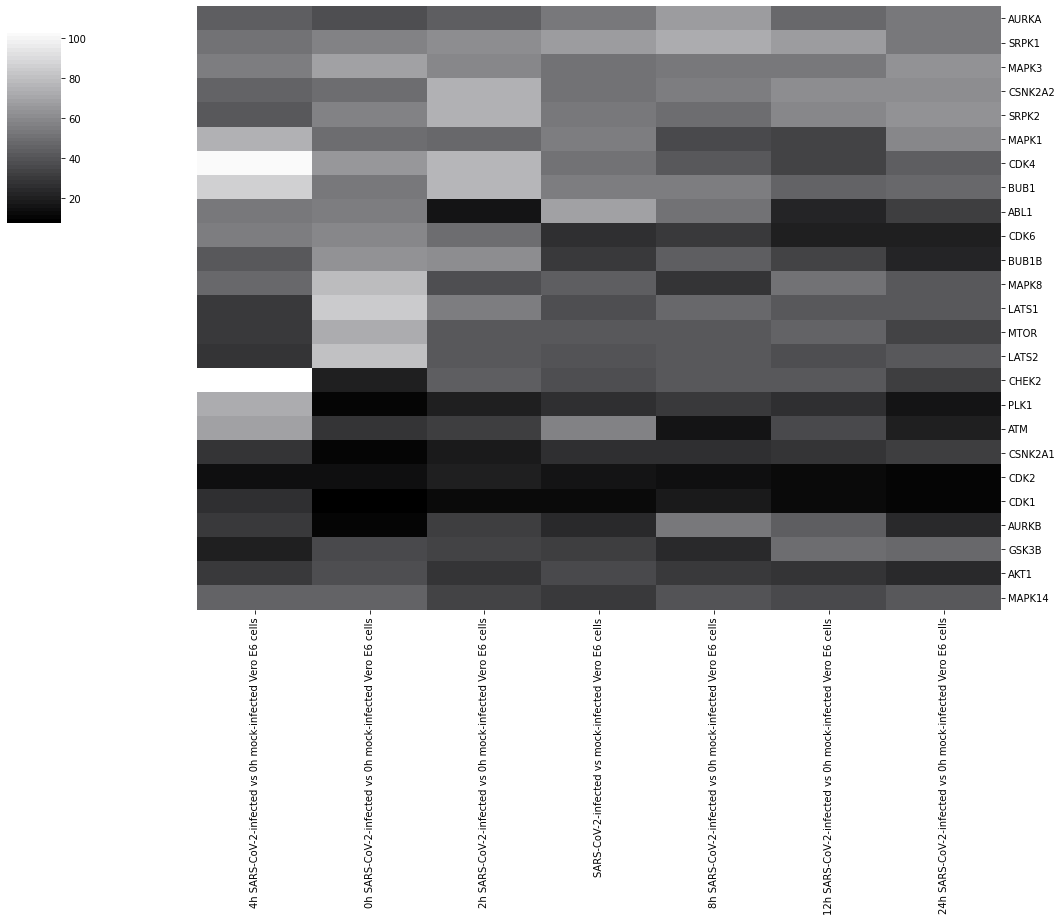

**Figure 1** Heatmap of top 25 kinases ranked by mean rank

In [15]:
figure = heatmap(consensus_df, method, figure, rev=True)

#### Scaled Mean Rank

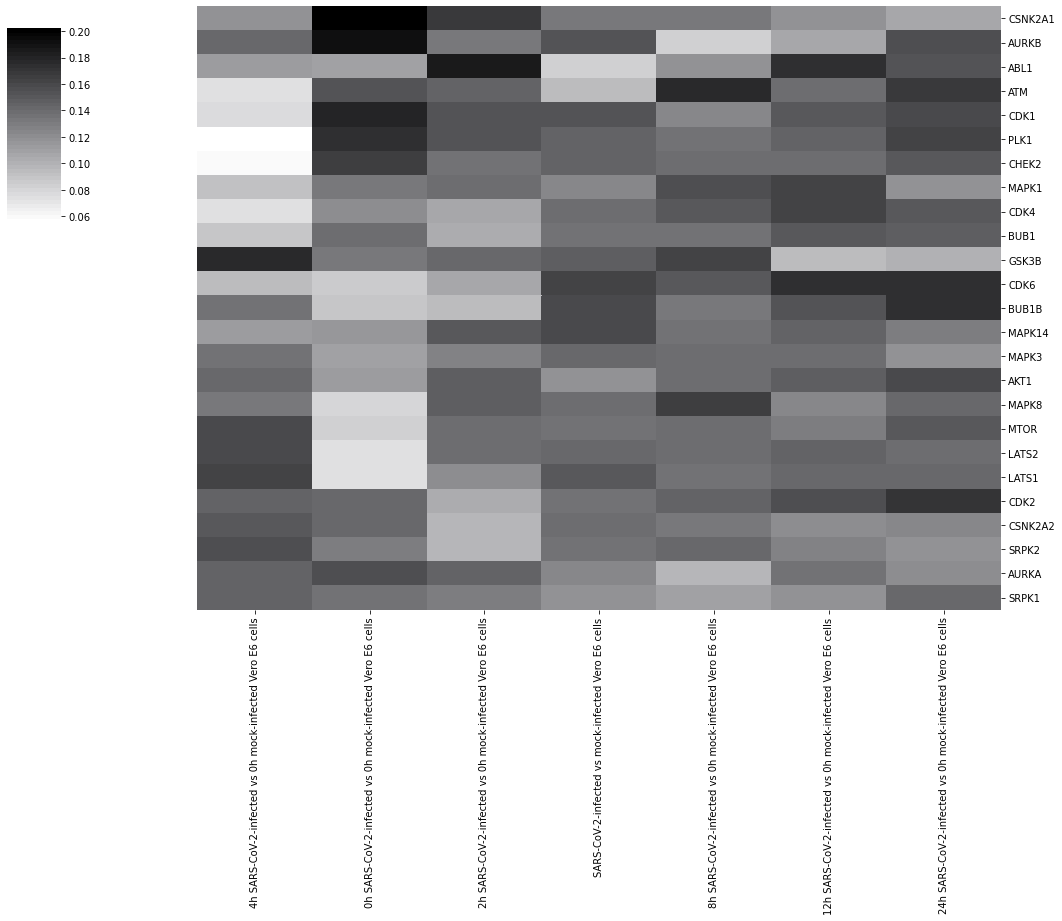

**Figure 2** Heatmap of top 25 kinases ranked by scaled mean rank

In [16]:
figure = heatmap(consensus_scaled, method, figure)

### Clustergrammer

In [17]:
figure = clustergrammer(consensus_scaled, method, figure)

**Figure 3** Clustergrammer of top 25 kinases                     ranked by scaled mean rank. [Go to url](https://maayanlab.cloud/clustergrammer/viz/6078918a97f268000e8d4bf3/Integrated--meanRank_clustergrammer.tsv)

### Stacked bar plot
#### Mean Rank

<AxesSubplot:xlabel='mean rank'>

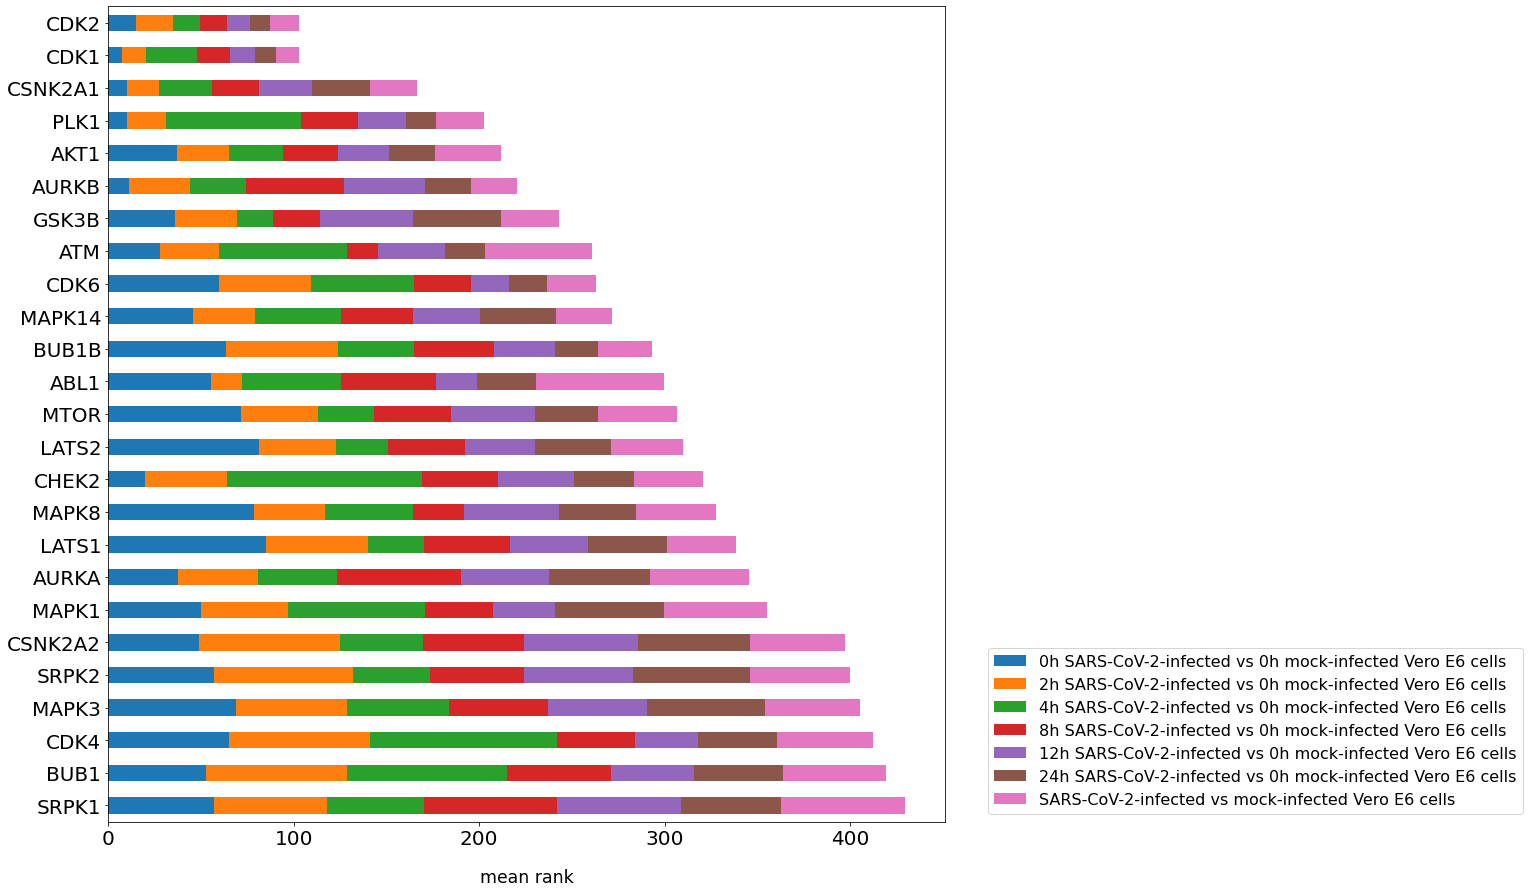

**Figure 4** Stacked bar chart of top 25 kinases ranked by mean rank

In [18]:
figure = stackedBarPlot(consensus_df, method, figure, rev=True)

#### Scaled Mean Rank

<AxesSubplot:xlabel='scaled mean rank'>

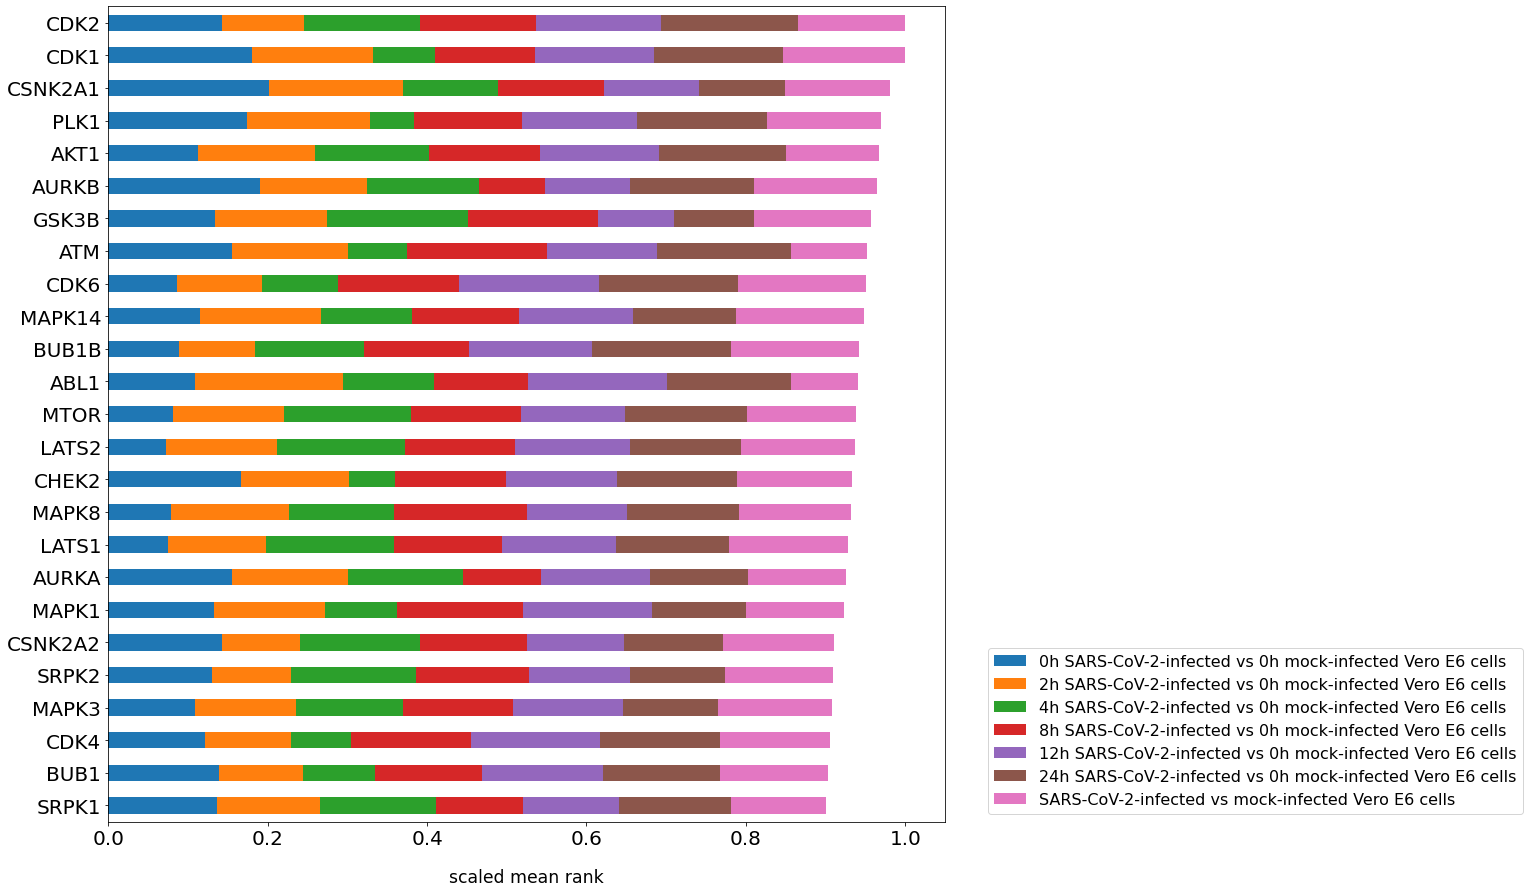

**Figure 4** Stacked bar chart of top 25 kinases ranked by scaled mean rank

In [19]:
figure = stackedBarPlot(consensus_scaled, method, figure)

## Top Rank

In [20]:
method = 'Integrated--topRank'
term_df,table = get_dataframe(enrichment, method, table)

,0h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,2h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,4h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,8h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,12h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,24h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,SARS-CoV-2-infected vs mock-infected Vero E6 cells
NTRK1,0.001927,0.003854,0.003854,0.002110,0.002110,0.004219,0.003854
AURKB,0.001946,0.009728,0.013490,0.015410,0.003891,0.001946,0.005780
PLK1,0.002315,0.009259,0.006944,0.020830,0.002315,0.002315,0.009259
CSNK2A1,0.002660,0.002660,0.002110,0.002660,0.002660,0.002660,0.002660
PAK1,0.002950,0.008850,0.017700,0.008850,0.023600,0.023600,0.011800
SRPK2,0.003854,0.001927,0.001927,0.001927,0.001927,0.001927,0.001927
SRPK1,0.003891,0.019270,0.001946,0.001946,0.009728,0.011670,0.003891
CDK2,0.004405,0.004405,0.004405,0.002315,0.004405,0.004167,0.004405
KSR1,0.004630,0.004630,0.021100,0.008439,0.008439,0.010550,0.012660
CDK1,0.005319,0.002950,0.005837,0.005319,0.005837,0.003891,0.005319


**Table 6** The table below shows the top rank of kinases for each of the         7 input gene sets [Download complete table](Integrated--topRank_df.tsv)

### Top Kinases and Consensus Matrix

In [21]:
top_kinase, consensus_df, consensus_scaled, table = get_consensus(term_df, method, table)

,scores
SRPK2,0.002202
CSNK2A1,0.002581
NTRK1,0.003133
CDK2,0.004072
CDK1,0.004925
AKT1,0.005057
AURKB,0.007456
SRPK1,0.007477
PLK1,0.007605
MAPK8,0.008007


**Table 7** Top 25 kinases ranked by the mean of top rank scores         [Download complete list](Integrated--topRank_top_kinase.tsv)

,0h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,2h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,4h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,8h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,12h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,24h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,SARS-CoV-2-infected vs mock-infected Vero E6 cells
SRPK2,0.003854,0.001927,0.001927,0.001927,0.001927,0.001927,0.001927
CSNK2A1,0.002660,0.002660,0.002110,0.002660,0.002660,0.002660,0.002660
NTRK1,0.001927,0.003854,0.003854,0.002110,0.002110,0.004219,0.003854
CDK2,0.004405,0.004405,0.004405,0.002315,0.004405,0.004167,0.004405
CDK1,0.005319,0.002950,0.005837,0.005319,0.005837,0.003891,0.005319
AKT1,0.008850,0.005900,0.002950,0.005900,0.002950,0.005900,0.002950
AURKB,0.001946,0.009728,0.013490,0.015410,0.003891,0.001946,0.005780
SRPK1,0.003891,0.019270,0.001946,0.001946,0.009728,0.011670,0.003891
PLK1,0.002315,0.009259,0.006944,0.020830,0.002315,0.002315,0.009259
MAPK8,0.011800,0.011800,0.014750,0.002950,0.005900,0.002950,0.005900


**Table 8** Consensus matrix of top 25 kinases ranked by the mean of top rank scores         [Download table](Integrated--topRank_consensus_matrix.tsv)

,0h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,2h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,4h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,8h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,12h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,24h SARS-CoV-2-infected vs 0h mock-infected Vero E6 cells,SARS-CoV-2-infected vs mock-infected Vero E6 cells
SRPK2,0.081633,0.153061,0.153061,0.153061,0.153061,0.153061,0.153061
CSNK2A1,0.138585,0.138585,0.168112,0.138585,0.138585,0.138585,0.138585
NTRK1,0.183507,0.118319,0.118319,0.177317,0.177317,0.105972,0.118319
CDK2,0.131825,0.131825,0.131825,0.199478,0.131825,0.139529,0.131825
CDK1,0.132841,0.190663,0.120198,0.132841,0.120198,0.167695,0.132841
AKT1,0.081400,0.128883,0.176366,0.128883,0.176366,0.128883,0.176366
AURKB,0.192917,0.121154,0.086461,0.068756,0.174981,0.192917,0.157561
SRPK1,0.168551,0.055141,0.182894,0.182894,0.125507,0.111186,0.168551
PLK1,0.178171,0.130805,0.146596,0.051877,0.178171,0.178171,0.130805
MAPK8,0.105506,0.105506,0.077101,0.190723,0.162318,0.190723,0.162318


**Table 9** Consensus matrix of top 25 kinases ranked by the scaled mean of top rank scores         [Download table](Integrated--topRank_consensus_scaled.tsv)

### Heat map
#### Top Rank

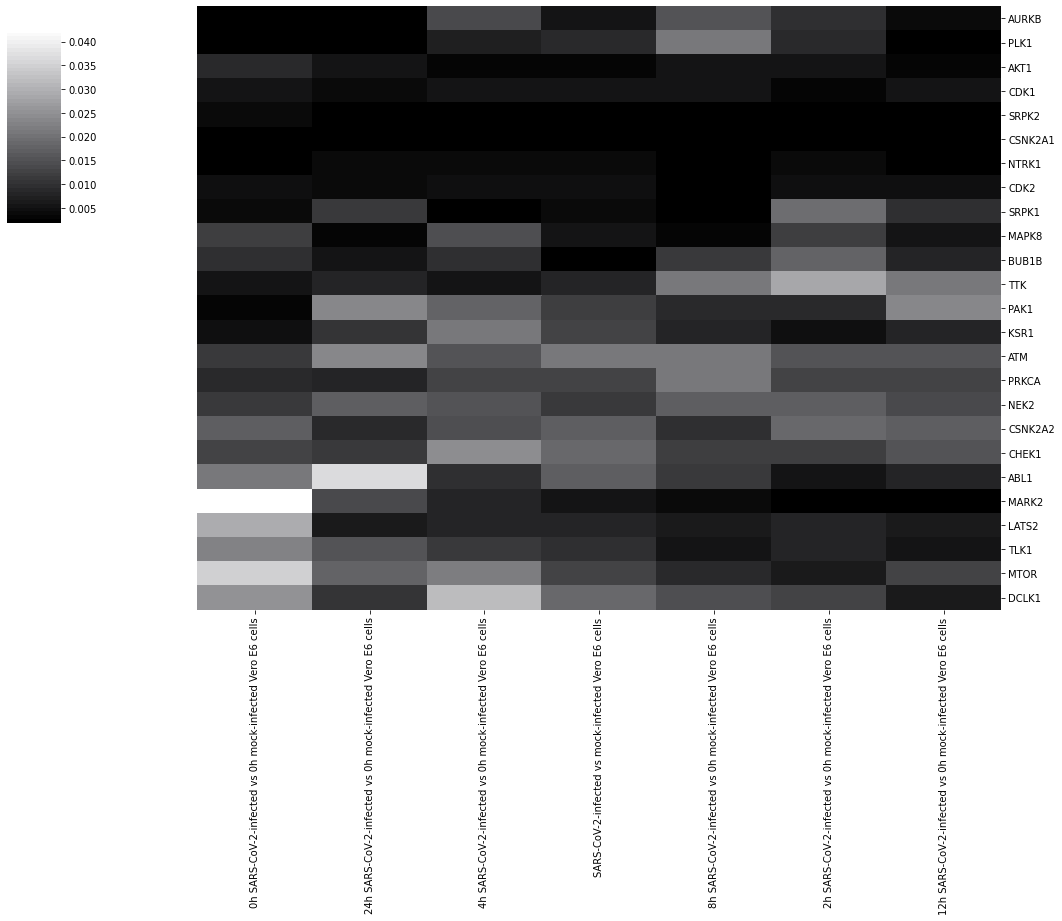

**Figure 4** Heatmap of top 25 kinases ranked by top rank

In [22]:
figure = heatmap(consensus_df, method, figure, rev=True)

#### Scaled Top Rank

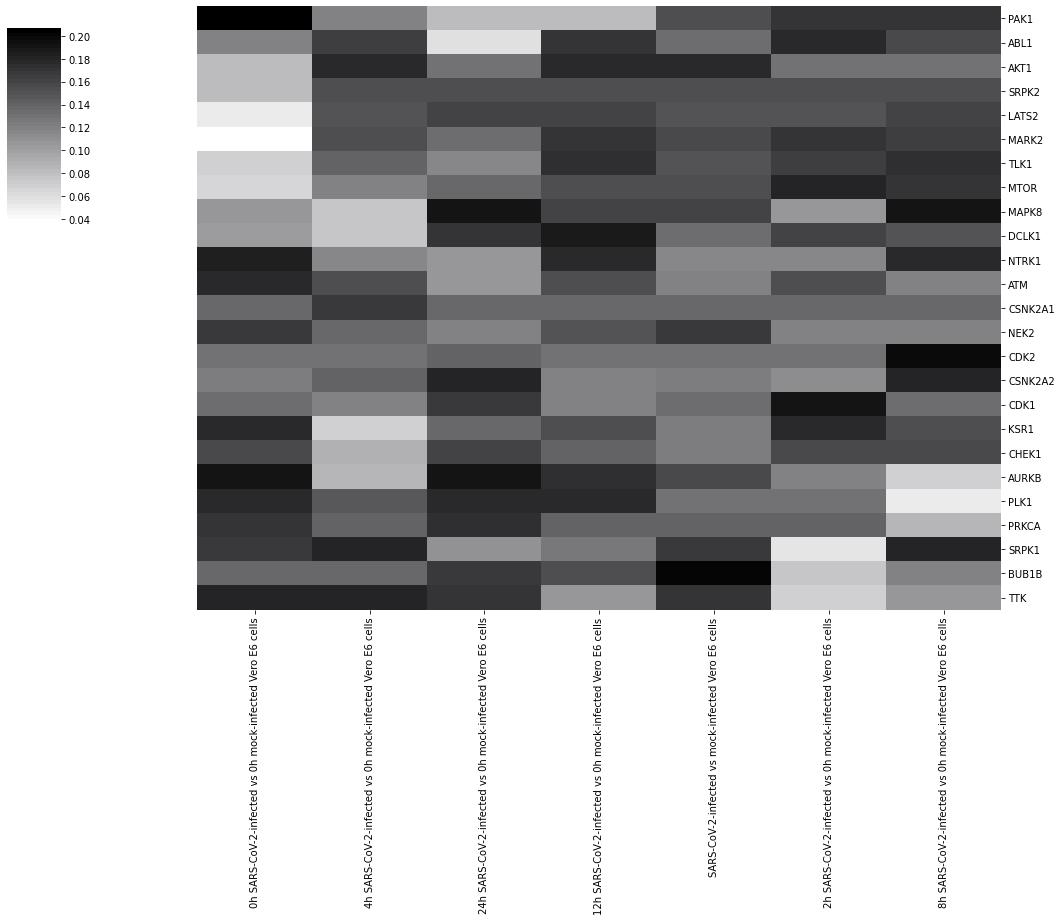

**Figure 5** Heatmap of top 25 kinases ranked by scaled top rank

In [23]:
figure = heatmap(consensus_scaled, method, figure)

### Clustergrammer

In [24]:
figure = clustergrammer(consensus_scaled, method, figure)

**Figure 6** Clustergrammer of top 25 kinases                     ranked by scaled top rank. [Go to url](https://maayanlab.cloud/clustergrammer/viz/6078919197f268000e8d4bf8/Integrated--topRank_clustergrammer.tsv)

### Stacked bar plot
#### Top Rank

<AxesSubplot:xlabel='top rank'>

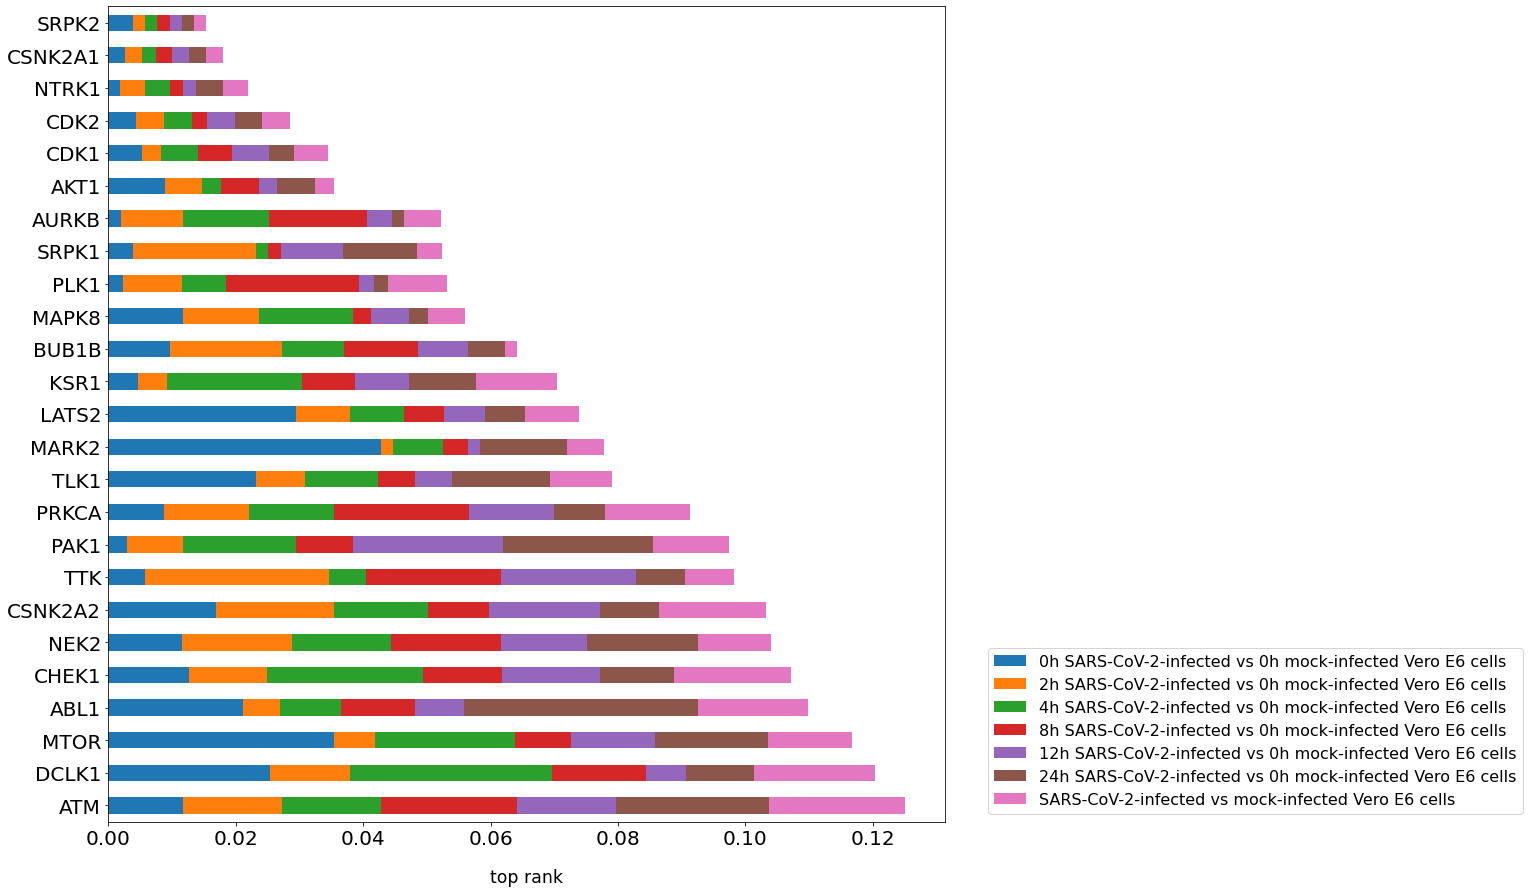

**Figure 7** Stacked bar chart of top 25 kinases ranked by top rank

In [25]:
figure = stackedBarPlot(consensus_df, method, figure, rev=True)

#### Scaled Top Rank

<AxesSubplot:xlabel='scaled top rank'>

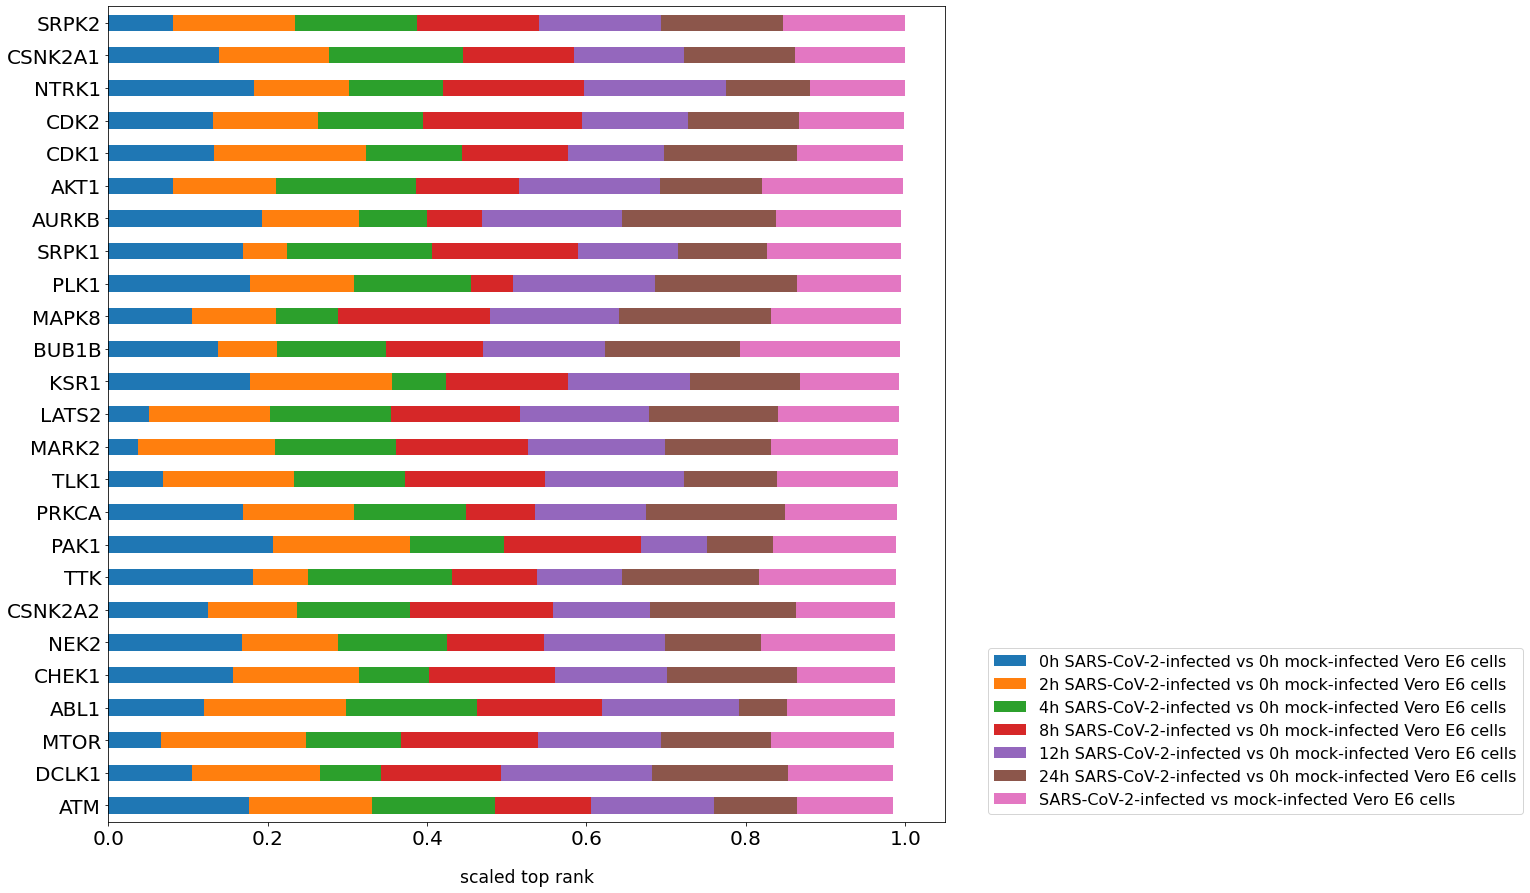

**Figure 7** Stacked bar chart of top 25 kinases ranked by scaled top rank

In [26]:
figure = stackedBarPlot(consensus_scaled, method, figure)

## References
[1] Lachmann A, Ma’ayan A. KEA: Kinase enrichment analysis. Bioinformatics 25(5) 684-6 (2009) PMID: 19176546

[2] Chen EY, Tan CM, Kou Y, Duan Q, Wang Z, Meirelles GV, Clark NR, Ma'ayan A.
Enrichr: interactive and collaborative HTML5 gene list enrichment analysis tool. BMC Bioinformatics. 2013; 128(14).

[3] Kuleshov MV, Jones MR, Rouillard AD, Fernandez NF, Duan Q, Wang Z, Koplev S, Jenkins SL, Jagodnik KM, Lachmann A, McDermott MG, Monteiro CD, Gundersen GW, Ma'ayan A.
Enrichr: a comprehensive gene set enrichment analysis web server 2016 update. Nucleic Acids Research. 2016; gkw377.

[4] Xie Z, Bailey A, Kuleshov MV, Clarke DJB., Evangelista JE, Jenkins SL, Lachmann A, Wojciechowicz ML, Kropiwnicki E, Jagodnik KM, Jeon M, & Ma’ayan A.
Gene set knowledge discovery with Enrichr. Current Protocols, 1, e90. 2021. doi: 10.1002/cpz1.90 

[5] Fernandez, N. F. et al. Clustergrammer, a web-based heatmap visualization and analysis tool for high-dimensional biological data. Sci. Data 4:170151 doi: 10.1038/sdata.2017.151 (2017).

[6] The COVID-19 Gene and Drug Set Library. Kuleshov et al. Patterns. 2020 Jul 25:100090

[7] Bouhaddou, Mehdi, et al. "The global phosphorylation landscape of SARS-CoV-2 infection." Cell 182.3 (2020): 685-712.